Task (a): Generate Data from Lotka-Volterra Model


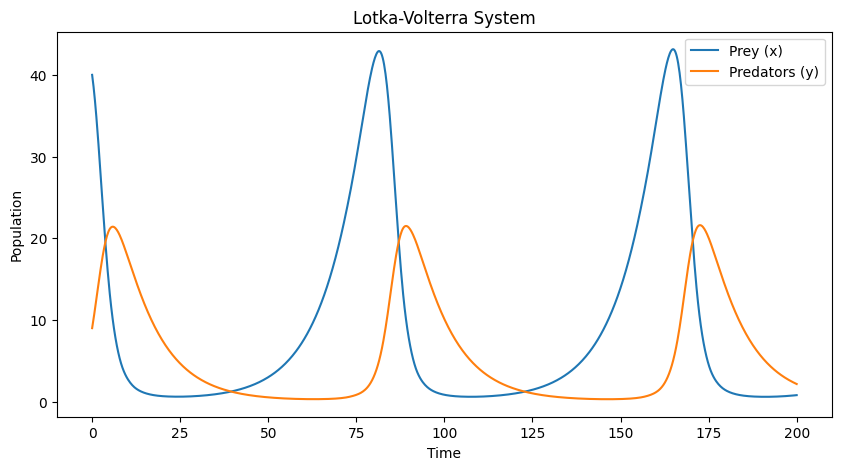

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the Lotka-Volterra equations
def lotka_volterra(t, z, alpha, beta, delta, gamma):
    x, y = z
    dxdt = alpha * x - beta * x * y
    dydt = -delta * y + gamma * x * y
    return [dxdt, dydt]

# Parameters
alpha, beta, delta, gamma = 0.1, 0.02, 0.1, 0.01
z0 = [40, 9]  # Initial population [Prey, Predator]
t_span = (0, 200)
t_eval = np.linspace(*t_span, 1000)

# Solve the system
sol = solve_ivp(lotka_volterra, t_span, z0, args=(alpha, beta, delta, gamma), t_eval=t_eval)

# Plot the generated data
plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[0], label="Prey (x)")
plt.plot(sol.t, sol.y[1], label="Predators (y)")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.title("Lotka-Volterra System")
plt.show()

# Save the generated data
np.savez("lotka_volterra_data.npz", t=sol.t, prey=sol.y[0], predator=sol.y[1])


Task (b): Construct UDE with Neural Networks


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a neural network to approximate the interaction terms
class InteractionNN(nn.Module):
    def __init__(self):
        super(InteractionNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate the neural network
interaction_nn = InteractionNN()


Task (c): Train the UDE using Generated Data


In [ ]:
# Prepare training data
t_data = torch.tensor(sol.t, dtype=torch.float32).view(-1, 1)
x_data = torch.tensor(sol.y[0], dtype=torch.float32).view(-1, 1)
y_data = torch.tensor(sol.y[1], dtype=torch.float32).view(-1, 1)
xy_data = torch.cat([x_data, y_data], dim=1)  # Shape: (1000, 2)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(interaction_nn.parameters(), lr=0.01)

# Train the model
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    predicted_interaction = interaction_nn(xy_data)  # Shape: (1000, 2)

    # Corrected true interaction terms (Ensure shape (1000, 2))
    true_interaction = torch.cat([
        (beta * x_data * y_data),
        (gamma * x_data * y_data)
    ], dim=1)

    loss = criterion(predicted_interaction, true_interaction)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

print("Training Complete!")


Epoch 0: Loss = 3.7543113231658936
Epoch 100: Loss = 0.0042103128507733345
Epoch 200: Loss = 0.003143131732940674
Epoch 300: Loss = 0.002711696084588766
Epoch 400: Loss = 0.0021616914309561253
Epoch 500: Loss = 0.0020532908383756876
Epoch 600: Loss = 0.0014599283458665013
Epoch 700: Loss = 0.001333564636297524
Epoch 800: Loss = 0.0010089885909110308
Epoch 900: Loss = 0.0007910711574368179
Training Complete!


Task (d): Compare Predictions with True Interaction Terms


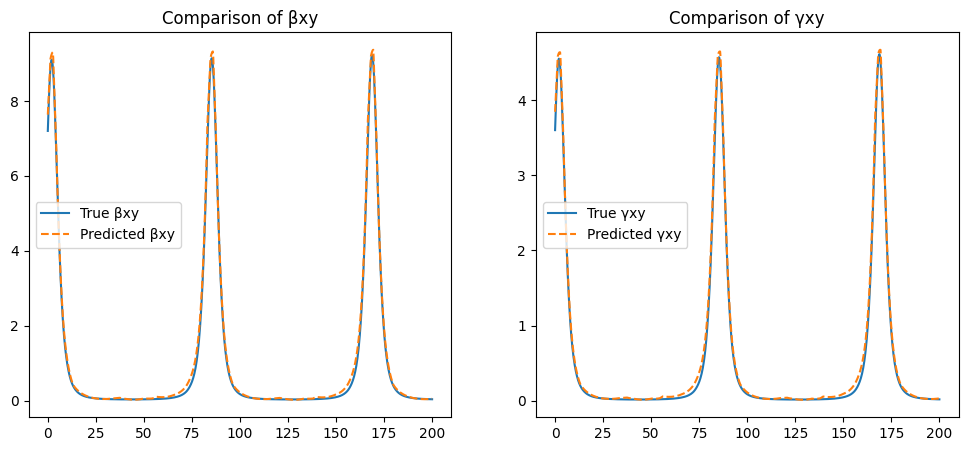

In [ ]:
# Predict interaction terms
with torch.no_grad():
    predicted_interaction = interaction_nn(xy_data).numpy()

# Convert to numpy
true_interaction = np.vstack([
    beta * sol.y[0] * sol.y[1],
    gamma * sol.y[0] * sol.y[1]
]).T

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(sol.t, true_interaction[:, 0], label="True βxy")
plt.plot(sol.t, predicted_interaction[:, 0], label="Predicted βxy", linestyle="dashed")
plt.legend()
plt.title("Comparison of βxy")

plt.subplot(1, 2, 2)
plt.plot(sol.t, true_interaction[:, 1], label="True γxy")
plt.plot(sol.t, predicted_interaction[:, 1], label="Predicted γxy", linestyle="dashed")
plt.legend()
plt.title("Comparison of γxy")

plt.show()
